In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [139]:
X = np.load('/kaggle/input/mai-mobile-emb/x.npy')
y = np.load('/kaggle/input/mai-mobile-emb/y.npy')
X.shape, y.shape


((1168, 1000), (1168,))

In [140]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, class_probs=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.class_probs = class_probs


In [8]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if depth == self.max_depth or n_labels == 1:
            y = y.astype(np.int)
            class_probs = np.bincount(y, minlength=self.n_classes) / len(y)
            return Node(class_probs=class_probs)

        # find best split
        best_gain = -1
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(y, X[:, feature], threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        # split data
        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold

        # grow subtrees
        left = self._grow_tree(X[left_indices, :], y[left_indices], depth+1)
        right = self._grow_tree(X[right_indices, :], y[right_indices], depth+1)

        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)

    def _information_gain(self, y, feature, threshold):
        # parent node entropy
        parent_entropy = self._entropy(y)

        # split data
        left_indices = feature < threshold
        right_indices = feature >= threshold

        # child node entropy
        left_entropy = self._entropy(y[left_indices])
        right_entropy = self._entropy(y[right_indices])

        # weighted sum of child node entropy
        n_left, n_right = len(y[left_indices]), len(y[right_indices])
        child_entropy = (n_left / len(y)) * left_entropy + (n_right / len(y)) * right_entropy

        # information gain
        gain = parent_entropy - child_entropy
        return gain

    def _entropy(self, y):
        # calculate class probabilities
        y = y.astype(np.int)
        counts = np.bincount(y, minlength=self.n_classes)
        probs = counts / len(y)

        # calculate entropy
        entropy = -np.sum(probs * np.log2(probs + 1e-10))
        return entropy

    def predict(self, X):
        return [self._traverse_tree(x, self.tree) for x in X]

    def predict_proba(self, X):
        return [self._traverse_tree_proba(x, self.tree) for x in X]


    def _traverse_tree(self, x, node):
        if node.class_probs is not None:
            return node.class_probs
        if x[node.feature] < node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)
        
    def _traverse_tree_proba(self, x, node):
        if node.class_probs is not None:
            return node.class_probs
        if x[node.feature] < node.threshold:
            return self._traverse_tree_proba(x, node.left)
        else:
            return self._traverse_tree_proba(x, node.right)


In [9]:
# Initialize the decision tree
tree = DecisionTreeClassifier(max_depth=50)

# Train the decision tree
tree.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to speci

In [10]:
# Make predictions on the testing data
y_pred = tree.predict_proba(X_test)
y_pred[:5]

[array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])]

In [11]:
y_p = np.array(y_pred)
y_pred = np.argmax(y_p,axis = 1)

In [12]:
# Evaluate the performance of the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.56


In [14]:
y_true_num = y_test
# call classification_report with numerical y_true and y_pred
report = classification_report(y_true_num, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.45      0.43      0.44        21
           1       0.48      0.48      0.48        21
           2       0.46      0.57      0.51        21
           3       0.50      0.57      0.53        21
           4       0.41      0.47      0.44        15
           5       0.41      0.64      0.50        14
           6       0.93      0.87      0.90        15
           7       0.65      0.73      0.69        15
           8       0.70      0.47      0.56        15
           9       0.53      0.53      0.53        15
          10       1.00      0.80      0.89        15
          11       0.78      0.44      0.56        16
          12       0.38      0.33      0.36        15
          13       0.71      0.67      0.69        15

    accuracy                           0.56       234
   macro avg       0.60      0.57      0.58       234
weighted avg       0.59      0.56      0.57       234



In [15]:
confusion_matrix(y_true_num, y_pred)

array([[ 9,  2,  1,  1,  0,  1,  0,  1,  0,  2,  0,  0,  3,  1],
       [ 2, 10,  2,  1,  0,  1,  0,  0,  0,  1,  0,  0,  3,  1],
       [ 1,  0, 12,  6,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  1,  4, 12,  2,  0,  0,  1,  0,  1,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  7,  4,  0,  0,  1,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  1,  3,  9,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  1, 13,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  1,  0, 11,  0,  0,  0,  1,  0,  0],
       [ 0,  1,  4,  0,  0,  0,  0,  2,  7,  1,  0,  0,  0,  0],
       [ 0,  3,  1,  1,  0,  0,  0,  1,  1,  8,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  1,  1,  0,  0,  0,  0, 12,  0,  0,  0],
       [ 0,  1,  0,  2,  2,  3,  0,  0,  0,  0,  0,  7,  1,  0],
       [ 3,  1,  0,  0,  1,  1,  0,  1,  0,  1,  0,  0,  5,  2],
       [ 3,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1, 10]])

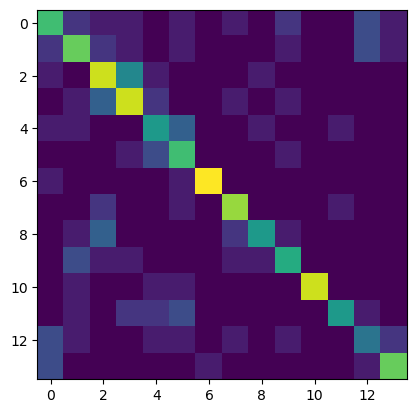

In [16]:
import matplotlib.pyplot as plt
plt.imshow(confusion_matrix(y_true_num, y_pred))

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# Make predictions on the testing data
y_pred = tree.predict_proba(X_test)
y_pred = np.array(y_pred)

# One-hot encode the labels
lb = LabelBinarizer()
y_true_num = lb.fit_transform(y_true_num)

In [18]:
y_true_num.shape, y_pred.shape

((234, 14), (234, 14))

In [19]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(14):
    fpr[i], tpr[i], _ = roc_curve(y_true_num[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

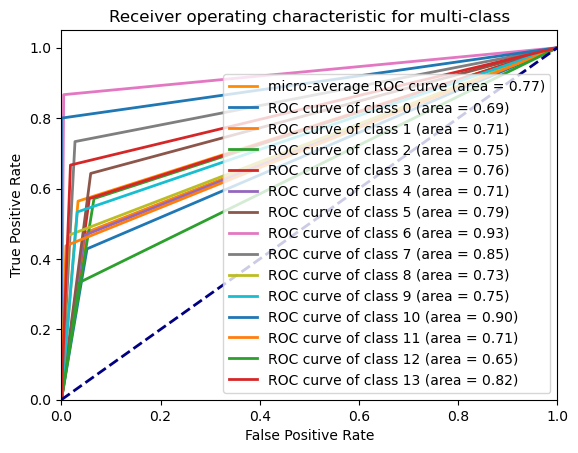

In [20]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_num.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
for i in range(14):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class %d (area = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

In [21]:
for i in range(14):
    print(f'ROC curve of class %d (area = %0.2f)' % (i, roc_auc[i]))

ROC curve of class 0 (area = 0.69)
ROC curve of class 1 (area = 0.71)
ROC curve of class 2 (area = 0.75)
ROC curve of class 3 (area = 0.76)
ROC curve of class 4 (area = 0.71)
ROC curve of class 5 (area = 0.79)
ROC curve of class 6 (area = 0.93)
ROC curve of class 7 (area = 0.85)
ROC curve of class 8 (area = 0.73)
ROC curve of class 9 (area = 0.75)
ROC curve of class 10 (area = 0.90)
ROC curve of class 11 (area = 0.71)
ROC curve of class 12 (area = 0.65)
ROC curve of class 13 (area = 0.82)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create arrays to store the training and validation scores
train_scores = []
val_scores = []

# Define the number of training examples to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Iterate through the training sizes and train the model with that many examples
for size in train_sizes:
    # Determine the number of examples to use for training
    n_train = int(size * len(X))

    # Train the model on the selected number of examples
    tree.fit(X[:n_train], y[:n_train])

    # Record the training and validation scores
    y_p = np.array(tree.predict(X[:n_train])).argmax(axis=1)
    train_score = accuracy_score(y_p , y[:n_train])
    val_score = accuracy_score(np.array(tree.predict(X[n_train:])).argmax(axis=1), y[n_train:])
    train_scores.append(train_score)
    val_scores.append(val_score)



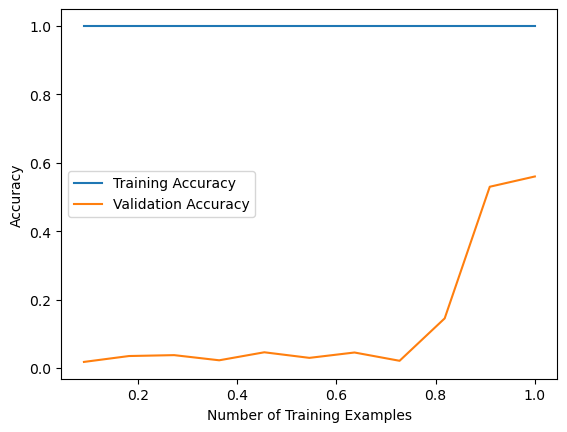

In [68]:
# Plot the learning curve
plt.plot(train_sizes, train_scores, label='Training Accuracy')
plt.plot(train_sizes, val_scores, label='Validation Accuracy')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# sklearn compare

Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.73      0.38      0.50        21
           1       0.57      0.62      0.59        21
           2       0.54      0.71      0.61        21
           3       0.47      0.43      0.45        21
           4       0.50      0.60      0.55        15
           5       0.40      0.43      0.41        14
           6       0.68      0.87      0.76        15
           7       0.44      0.53      0.48        15
           8       0.80      0.80      0.80        15
           9       0.53      0.53      0.53        15
          10       0.57      0.53      0.55        15
          11       0.62      0.31      0.42        16
          12       0.38      0.40      0.39        15
          13       0.60      0.60      0.60        15

    accuracy                           0.55       234
   macro avg       0.56      0.55      0.55       234
weighted avg       0.56      0.55      0.55       234



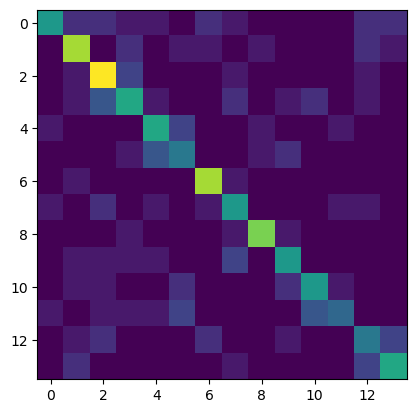

In [71]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

clf.fit(X_train,  y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# call classification_report with numerical y_true and y_pred
report = classification_report(y_test, y_pred)
print(report)

plt.imshow(confusion_matrix(y_test, y_pred))

Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.88      1.00      0.93        21
           2       0.74      0.95      0.83        21
           3       0.94      0.76      0.84        21
           4       0.75      1.00      0.86        15
           5       0.92      0.79      0.85        14
           6       0.88      1.00      0.94        15
           7       0.87      0.87      0.87        15
           8       0.79      0.73      0.76        15
           9       0.87      0.87      0.87        15
          10       1.00      0.80      0.89        15
          11       0.92      0.75      0.83        16
          12       0.79      0.73      0.76        15
          13       0.93      0.87      0.90        15

    accuracy                           0.86       234
   macro avg       0.87      0.86      0.86       234
weighted avg       0.87      0.86      0.86       234



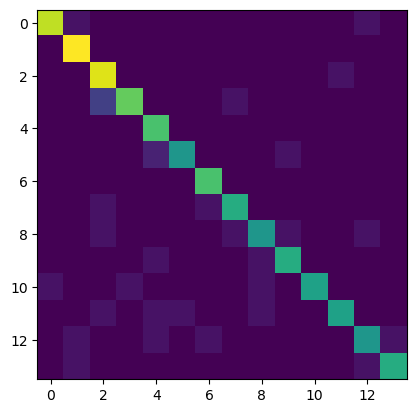

In [72]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()

clf.fit(X_train,  y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# call classification_report with numerical y_true and y_pred
report = classification_report(y_test, y_pred)
print(report)

plt.imshow(confusion_matrix(y_test, y_pred))

Accuracy: 0.97
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        21
           2       0.91      0.95      0.93        21
           3       0.95      0.90      0.93        21
           4       1.00      0.93      0.97        15
           5       0.82      1.00      0.90        14
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        15
          11       0.93      0.88      0.90        16
          12       1.00      0.93      0.97        15
          13       1.00      1.00      1.00        15

    accuracy                           0.97       234
   macro avg       0.97      0.97      0.97       234
weighted avg       0.97      0.97      0.97       234



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


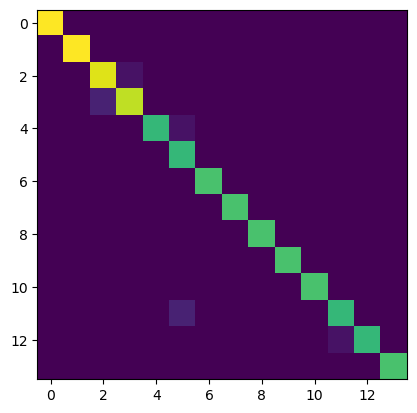

In [141]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(X_train,  y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# call classification_report with numerical y_true and y_pred
report = classification_report(y_test, y_pred)
print(report)

plt.imshow(confusion_matrix(y_test, y_pred))

Accuracy: 0.95
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.91      1.00      0.95        21
           2       0.86      0.90      0.88        21
           3       0.86      0.86      0.86        21
           4       0.94      1.00      0.97        15
           5       0.88      1.00      0.93        14
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        15
          11       0.93      0.81      0.87        16
          12       1.00      0.87      0.93        15
          13       1.00      1.00      1.00        15

    accuracy                           0.95       234
   macro avg       0.96      0.95      0.95       234
weighted avg       0.95      0.95      0.95       234



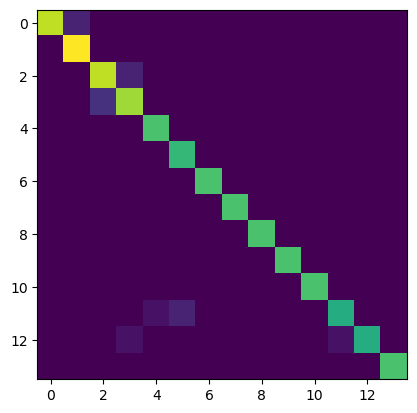

In [142]:
from sklearn.svm import SVC
clf = SVC()

clf.fit(X_train,  y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# call classification_report with numerical y_true and y_pred
report = classification_report(y_test, y_pred)
print(report)

plt.imshow(confusion_matrix(y_test, y_pred))

Accuracy: 0.94
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       1.00      1.00      1.00        21
           2       0.95      0.90      0.93        21
           3       0.87      0.95      0.91        21
           4       0.70      0.93      0.80        15
           5       0.86      0.86      0.86        14
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      0.93      0.97        15
           9       0.94      1.00      0.97        15
          10       1.00      1.00      1.00        15
          11       1.00      0.75      0.86        16
          12       0.93      0.87      0.90        15
          13       1.00      1.00      1.00        15

    accuracy                           0.94       234
   macro avg       0.95      0.94      0.94       234
weighted avg       0.95      0.94      0.94       234



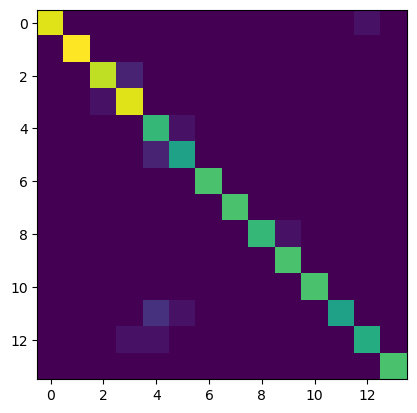

In [164]:
from sklearn.neighbors import KNeighborsClassifier 
clf = KNeighborsClassifier()

clf.fit(X_train,  y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# call classification_report with numerical y_true and y_pred
report = classification_report(y_test, y_pred)
print(report)

plt.imshow(confusion_matrix(y_test, y_pred))

Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.93      0.67      0.78        21
           1       0.88      1.00      0.93        21
           2       0.80      0.76      0.78        21
           3       0.73      0.76      0.74        21
           4       0.79      1.00      0.88        15
           5       0.91      0.71      0.80        14
           6       1.00      1.00      1.00        15
           7       1.00      0.87      0.93        15
           8       0.93      0.93      0.93        15
           9       0.88      0.93      0.90        15
          10       1.00      0.93      0.97        15
          11       0.72      0.81      0.76        16
          12       0.63      0.80      0.71        15
          13       1.00      0.87      0.93        15

    accuracy                           0.85       234
   macro avg       0.87      0.86      0.86       234
weighted avg       0.87      0.85      0.86       234



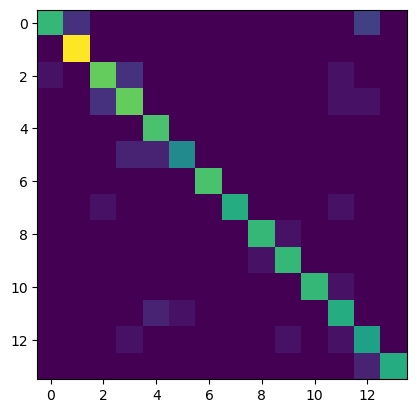

In [165]:
from sklearn.naive_bayes import BernoulliNB 
clf = BernoulliNB()

clf.fit(X_train,  y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# call classification_report with numerical y_true and y_pred
report = classification_report(y_test, y_pred)
print(report)

plt.imshow(confusion_matrix(y_test, y_pred))